In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Variable Definitions

#### E   = event identity stamp
#### T   = event time stamp

### Event Stamps ( array E )

- 1  = Rt lever press during DRL
- 2  = Lt lever press during DRL
- 5  = Reinforcement delivery
- 7  = Magazine head entry during DRL
- 29 = Traylight turns off (trial ends)
- 37 = DRL reset, respond too early
- 39 = Extend right lever
- 40 = Extend left lever
- 100 = End of session marker

\   Event stamps ( array E )
\
\   1  = Rt lever press during DRL
\   2  = Lt lever press during DRL
\   3  = Rt lever press during ITI
\   4  = Lt lever press during ITI
\   5  = Reinforcement delivery
\   7  = Magazine head entry during DRL
\   16 = ITI over
\   24 = Magazine head entry during ITI
\   28 = Traylight turns on
\   29 = Traylight turns off
\   33 = ITI starts
\   34 = House light turns on
\   35 = House light turns off
\   36 = DRL time up, waiting for press to get reward
\   37 = DRL reset, respond too early
\   38 = Manual pellet delivery
\   39 = Extend right lever
\   40 = Extend left lever
\  100 = End of session marker

In [2]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = int(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [102]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(str(event_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        if re.search(str(time_letter + ':'), str(array[i])):
            i = i + 1
            try:
                while re.search('\[\'\ \ ', str(array[i])):
                    split = array[i][0].split()[1:]
                    for element in split:
                        time_data.append(float(element))
                    i = i + 1
            except:
                pass
        i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [145]:
def get_trial_times_DRL(events_and_times, trial_end, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for pellet deliveries and end of trial segment
    #finds time_stamps for each start and end, puts into new dataframe

    session_start = np.array(events_and_times.iloc[[0]]['time_stamp'].values)
    session_end = list(events_and_times[events_and_times['event_stamp'] == session_end]['time_stamp'].values)
    trial_end_times = list(events_and_times[events_and_times['event_stamp'] == trial_end]['time_stamp'].values)
    
    start_times = np.append(session_start, trial_end_times)
    end_times = np.append(trial_end_times, session_end)

    times = pd.DataFrame(data = [start_times, end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

In [146]:
def create_trial_df(events_and_times, trial_times):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i] - .01)]
        data['trial_#'] = [i]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [147]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [175]:
def latency(trial_data, event_num):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_IRT = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_IRT.append(np.nan)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
            latency_IRT.append(data['time_stamp'].diff().mean()/100)
        i = i + 1
    
    return latency_1st, latency_IRT

In [176]:
def create_session_df(trial_data, event_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_IRT')] = latency(trial_data, event)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Single directory run

In [6]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

163
163


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_3_1116_210115'

### Read in animal data

In [158]:
#read animal info (lever assignment, group etc) into df

path_animal_info = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/PCA_PD_DRL_210101_meta.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

animal_info.head()

,cage,animal,group,lever
0,279,1116,4,1
1,279,1117,4,1
2,279,1118,4,1
3,283,1128,5,1
4,283,1130,5,1


### Process data

In [197]:
%%time
final_data = pd.DataFrame()

bit_dic = {'LP_right': 1, 'LP_left': 2, 'HE': 7, 'reinforcement': 5, 'DRL_reset': 37}

for file in file_paths:

    print(file) 
    
    if file.split('/')[-1] == '.DS_Store':
        continue
        
    #proccess file
    task, session, animal, date = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E", "T")
    trial_times = get_trial_times_DRL(events_and_times, 29, 100)
    trial_data = create_trial_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
   
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])    
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['active_lever'] = int(animal_info[animal_info['animal'] == int(animal)]['lever'])
    session_data['group'] = int(animal_info[animal_info['animal'] == int(animal)]['group'])
    session_data['cage'] = int(animal_info[animal_info['animal'] == int(animal)]['cage'])
   
    session_data = session_data[['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 'trial_num', 
                                 'reinforcement_count', 'trial_duration',
                                 'HE_count', 'HE_latency_1st', 'HE_latency_IRT',
                                 'LP_right_count', 'LP_right_latency_1st', 'LP_right_latency_IRT', 
                                 'LP_left_count', 'LP_left_latency_1st', 'LP_left_latency_IRT',
                                 'DRL_reset_count', 'DRL_reset_latency_1st', 'DRL_reset_latency_IRT']]
    
    #add to final data frame
    final_data = pd.concat([final_data, session_data], axis = 0, ignore_index=True)

final_data.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_3_1116_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_1_1124_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_2_1118_210116
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_3_1123_210120
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_1_1136_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_2_1120_210119
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_1_1128_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_3_1118_210122
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL30_1_1128_210122
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_3_1143_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_2_1122_210114
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL30_3_1118_210125
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_1_1129_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL30_2_1117_210123
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL30_2_1122_210121
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_2_1143_210114
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL30_3_1143_210122
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL30_1_1145_210120
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_1_1135_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL15_3_1120_210120
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/me

,task,date,session,cage,animal,group,active_lever,trial_num,reinforcement_count,trial_duration,HE_count,HE_latency_1st,HE_latency_IRT,LP_right_count,LP_right_latency_1st,LP_right_latency_IRT,LP_left_count,LP_left_latency_1st,LP_left_latency_IRT,DRL_reset_count,DRL_reset_latency_1st,DRL_reset_latency_IRT,DRL_error
0,DRL5,210115,3,279,1116,4,1,0,1,1384.39,39,31.03,32.679474,1,1384.37,NaN,0,NaN,NaN,0,NaN,NaN,0.000000
1,DRL5,210115,3,279,1116,4,1,1,1,1060.62,48,132.66,16.264468,1,1060.60,NaN,0,NaN,NaN,0,NaN,NaN,0.000000
2,DRL5,210115,3,279,1116,4,1,2,0,254.99,30,97.27,5.241034,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN
3,DRL15,210118,1,281,1124,4,2,0,1,48.70,7,1.82,1.998333,0,NaN,NaN,6,0.82,9.572,5,0.82,3.83,0.833333
4,DRL15,210118,1,281,1124,4,2,1,1,43.35,2,1.47,5.550000,0,NaN,NaN,1,43.33,NaN,0,NaN,NaN,0.000000


In [205]:
#calculate percent erro
final_data['DRL_error'] = final_data['DRL_reset_count'] / (final_data['DRL_reset_count'] + final_data['reinforcement_count'])

#get single column for lever params (based on active_lever)

def lever_convert(a, b, c):
    if a == 1:
        x = b
    if a == 2:
        x = c
        
    return x

final_data['LP_count'] = final_data.apply(lambda row : lever_convert(row['active_lever'], 
                                                                     row['LP_right_count'], 
                                                                     row['LP_left_count']), axis = 1)

final_data['LP_latency_1st'] = final_data.apply(lambda row : lever_convert(row['active_lever'], 
                                                                     row['LP_right_latency_1st'], 
                                                                     row['LP_left_latency_1st']), axis = 1)

final_data['LP_latency_IRT'] = final_data.apply(lambda row : lever_convert(row['active_lever'], 
                                                                     row['LP_right_latency_IRT'], 
                                                                     row['LP_left_latency_IRT']), axis = 1)

final_data = final_data[['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 'trial_num', 
                         'reinforcement_count', 'trial_duration', 'HE_count', 'HE_latency_1st', 'HE_latency_IRT', 
                         'DRL_reset_count', 'DRL_reset_latency_1st', 'DRL_reset_latency_IRT', 'DRL_error', 
                         'LP_count', 'LP_latency_1st', 'LP_latency_IRT']]

In [214]:
sum_params = ['reinforcement_count', 'HE_count', 'DRL_reset_count', 'LP_count']
final_data_sum = final_data.groupby(['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever'])[sum_params].sum().reset_index()

mean_params = ['trial_duration', 'HE_latency_1st', 'HE_latency_IRT', 
               'DRL_reset_latency_1st', 'DRL_reset_latency_IRT', 'DRL_error', 
               'LP_latency_1st', 'LP_latency_IRT']
final_data_mean = final_data.groupby(['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever'])[mean_params].mean().reset_index()

DRL_data = final_data_sum.merge(final_data_mean, on=['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever'])

In [215]:
DRL_data.to_csv('DRL_data.csv', index=False)

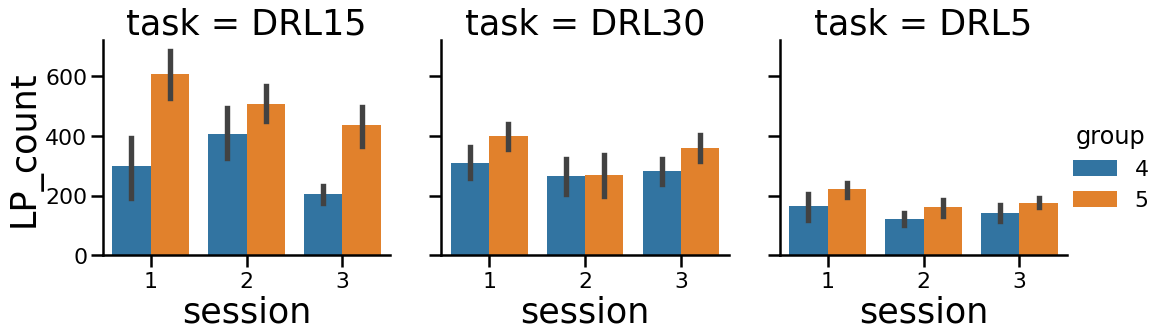

In [230]:
sns.catplot(x='session', y='LP_count', data=DRL_data, kind='bar', col='task', hue='group', ci=68)

In [177]:
file_path = file_paths[2]
print('file_path:', '\n', file_path, '\n')

task, session, animal, date = get_file_info(file_path)
print('task:', task, 'date:', date, 'animal:', animal, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E", "T")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_DRL(events_and_times, 29, 100)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times)
print(trial_data.head(), '\n')

bit_dic = {'LP_right': 1, 'LP_left': 2, 'HE_trial': 7, 'reinforcement': 5, 'DRL_reset': 37}
session_data = create_session_df(trial_data, bit_dic)
session_data

file_path: 
 /Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/DRL/DRL5_2_1118_210116 

task: DRL5 date: 210116 animal: 1118 session: 2 

[['Start Date: 01/16/21']
 ['End Date: 01/16/21']
 ['Subject: 1118']
 ['Experiment: 0']
 ['Group: 0']] 

   event_stamp  time_stamp
0         34.0         0.0
1         39.0         0.0
2          7.0        59.0
3          7.0        73.0
4          1.0       336.0 

   trial_start  trial_end
0          0.0     3355.0
1       3355.0     4776.0
2       4776.0     5805.0
3       5805.0     6895.0
4       6895.0    13488.0 

   event_stamp  time_stamp  trial_#  trial_start  trial_end
0         34.0         0.0        0          0.0     3355.0
1         39.0         0.0        0          0.0     3355.0
2          7.0        59.0        0          0.0     3355.0
3          7.0        73.0        0          0.0     3355.0
4          1.0       336.0        0          0.0     3355.0 



,LP_right_count,LP_right_latency_1st,LP_right_latency_IRT,LP_left_count,LP_left_latency_1st,LP_left_latency_IRT,HE_trial_count,HE_trial_latency_1st,HE_trial_latency_IRT,reinforcement_count,reinforcement_latency_1st,reinforcement_latency_IRT,DRL_reset_count,DRL_reset_latency_1st,DRL_reset_latency_IRT,trial_num,trial_duration
0,24,3.36,1.311739,0,NaN,NaN,9,0.59,3.691250,1,33.54,NaN,23,3.36,1.128636,0,33.55
1,2,0.38,13.810000,0,NaN,NaN,1,11.31,NaN,1,14.20,NaN,1,0.38,NaN,1,14.21
2,1,10.27,NaN,0,NaN,NaN,1,7.11,NaN,1,10.28,NaN,0,NaN,NaN,2,10.29
3,1,10.88,NaN,0,NaN,NaN,0,NaN,NaN,1,10.89,NaN,0,NaN,NaN,3,10.90
4,37,3.19,1.742222,0,NaN,NaN,14,13.40,3.826154,1,65.92,NaN,36,3.19,1.579143,4,65.93
5,4,0.19,4.266667,0,NaN,NaN,0,NaN,NaN,1,13.00,NaN,3,0.19,0.445000,5,13.01
6,1,27.81,NaN,0,NaN,NaN,4,5.60,6.956667,1,27.82,NaN,0,NaN,NaN,6,27.83
7,1,10.15,NaN,0,NaN,NaN,0,NaN,NaN,1,10.16,NaN,0,NaN,NaN,7,10.17
8,12,3.65,2.310909,0,NaN,NaN,6,5.86,3.488000,1,29.08,NaN,11,3.65,1.439000,8,29.09
9,3,0.32,6.705000,0,NaN,NaN,0,NaN,NaN,1,13.74,NaN,2,0.32,0.200000,9,13.75


In [178]:
session_data.columns

Index(['LP_right_count', 'LP_right_latency_1st', 'LP_right_latency_IRT', 'LP_left_count', 'LP_left_latency_1st', 'LP_left_latency_IRT', 'HE_trial_count', 'HE_trial_latency_1st', 'HE_trial_latency_IRT', 'reinforcement_count', 'reinforcement_latency_1st', 'reinforcement_latency_IRT', 'DRL_reset_count', 'DRL_reset_latency_1st', 'DRL_reset_latency_IRT', 'trial_num', 'trial_duration'], dtype='object')